In [1]:
import numpy as np
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Simulate data
np.random.seed(54321)
p = 2

def generate_Xy(n_samples, p=2, sigma=1):
    # Half of y is 1s, other half is -1
    y = np.ones(n_samples)
    mid = int(n_samples / 2)
    y[mid:] *= -1
    
    X = np.random.normal(0, sigma, (n_samples, p))
    X[y == 1] /= 10
    X += (1 - y[:, np.newaxis]) / 2 # add 1 when y = -1
    # X of shape (n, p)
    # y vector of length n
    return X, y

# Training data
X_train, y_train = generate_Xy(100, sigma=2)

# Testing data
X_test, y_test = generate_Xy(1000, sigma=2)

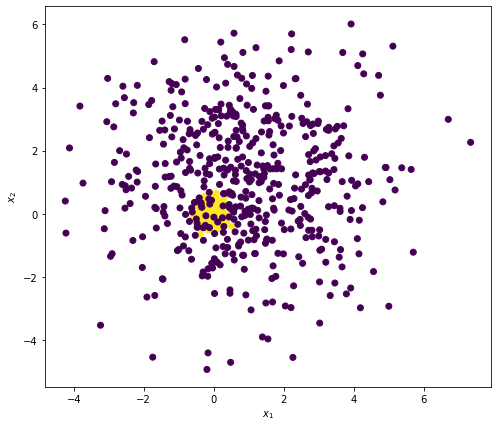

In [3]:
# Visualize training data
def plot_data(X, y):
    plt.figure(figsize=(8,7))
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.show()
    
plot_data(X_test, y_test)

In [4]:
# Prediction error
def error(ypred, ytrue):
    e = (ypred != ytrue).mean()
    return e

def add_column_ones(X):
    n = X.shape[0]
    return np.hstack([X, np.ones((n, 1))])

# Visualization
# References: https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(classifier, xx, yy, add_intercept=False, **params):
    """Plot the decision boundaries for a classifier.
    
    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    X = np.c_[xx.ravel(), yy.ravel()]
    if add_intercept:
        X = add_column_ones(X)
    Z = classifier.predict(X)
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

def plot_decision_function(classifier, X_train, y_train, title='', add_intercept=False):
    fig = plt.figure(figsize=(8,7))
    X0, X1 = X_train[:, 0], X_train[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(classifier, xx, yy, cmap=plt.cm.GnBu, alpha=0.5, add_intercept=add_intercept)
    plt.scatter(X0, X1, c=y_train, cmap=plt.cm.GnBu, s=20, edgecolors='k')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title(title)
    plt.show()
    
def plot_decision_function_K(
    classifier, kernel_function,
    X_train, y_train, X_plot=None, y_plot=None, title=''):

    fig = plt.figure(figsize=(8,7))
    X0, X1 = X_plot[:, 0], X_plot[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    X = np.c_[xx.ravel(), yy.ravel()]
    K = kernel_function(X, X_train)
    Z = classifier.predict_K(K)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.GnBu, alpha=0.5)
    plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, cmap=plt.cm.GnBu, s=20, edgecolors='k')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title(title)
    plt.show()

## KernelSVM
***

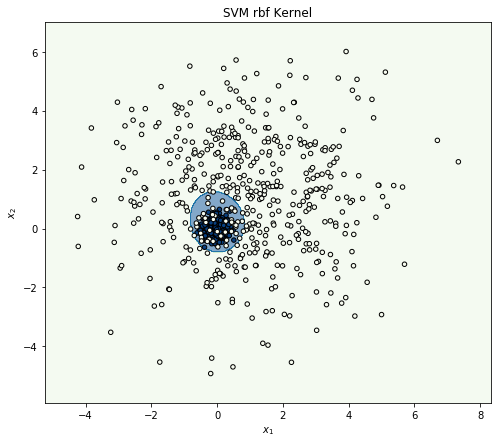

Test error: 5.20%


In [7]:
from kernel_svm import KernelSVM

kernel = 'rbf'
sigma = 1.
C = 1.
model = KernelSVM(C=C, kernel=kernel, sigma=sigma)
y_pred = model.fit(X_train, y_train, tol=1e-5).predict(X_test)
plot_decision_function(model, X_test, y_test,
                       title='SVM {} Kernel'.format(kernel))
print('Test error: {:.2%}'.format(error(y_pred, y_test)))

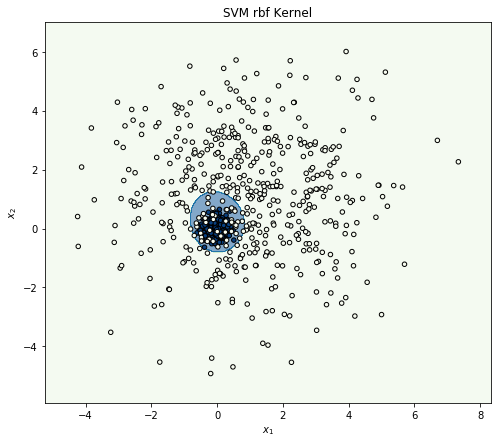

Test error: 5.20%


In [8]:
from kernel_functions import *
# Precomputing kernel:
sigma = 1.
kernel_function = lambda x, y: rbf_kernel(x, y, sigma=sigma)
K_rbf_train = kernel_function(X_train, X_train)
K_rbf_test = kernel_function(X_test, X_train)
C = 1.
model = KernelSVM(C=C)
y_pred = model.fit_K(K_rbf_train, y_train).predict_K(K_rbf_test)

plot_decision_function_K(model, kernel_function, X_train, y_train, X_test, y_test, title='SVM {} Kernel'.format(kernel))
print('Test error: {:.2%}'.format(error(y_pred, y_test)))

## KernelRidgeRegression
***

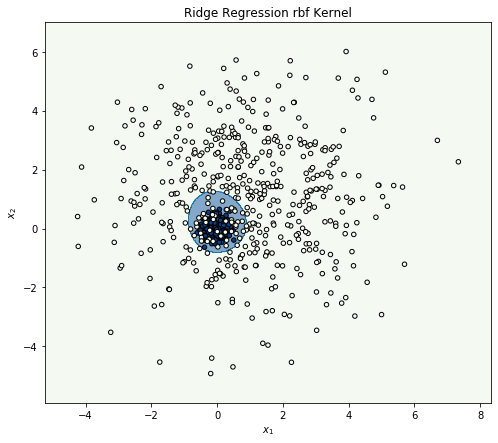

Test error: 5.40%


In [9]:
from kernel_ridge import KernelRidgeClassifier

kernel = 'rbf'
sigma = 1.
lambd = .01
model = KernelRidgeClassifier(lambd=lambd, kernel=kernel, sigma=sigma)
y_pred = model.fit(X_train, y_train).predict(X_test)
plot_decision_function(model, X_test, y_test,
                       title='Ridge Regression {} Kernel'.format(kernel))
print('Test error: {:.2%}'.format(error(y_pred, y_test)))

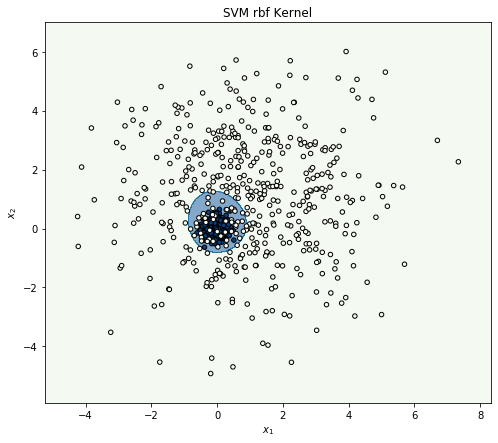

Test error: 5.40%


In [10]:
# Precomputing kernel:
sigma = 1.
kernel_function = lambda x, y: rbf_kernel(x, y, sigma=sigma)
K_rbf_train = kernel_function(X_train, X_train)
K_rbf_test = kernel_function(X_test, X_train)
C = .1
model = KernelRidgeClassifier(lambd=lambd)
y_pred = model.fit_K(K_rbf_train, y_train).predict_K(K_rbf_test)

plot_decision_function_K(model, kernel_function, X_train, y_train, X_test, y_test, title='SVM {} Kernel'.format(kernel))
print('Test error: {:.2%}'.format(error(y_pred, y_test)))

## KernelLogisticRegression
***

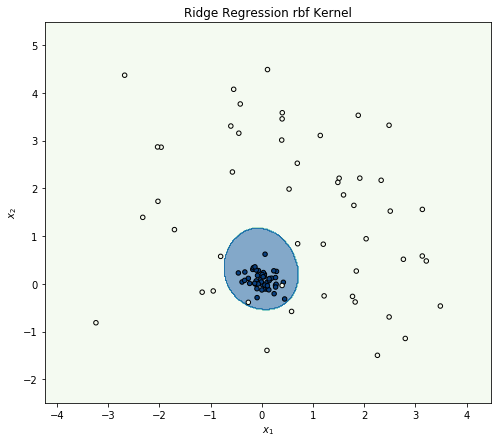

Test error: 4.70%


In [11]:
from kernel_ridge import KernelLogisticRegression

kernel = 'rbf'
sigma = 1.
lambd = .0001
model = KernelLogisticRegression(lambd=lambd, kernel=kernel, sigma=sigma)
y_pred = model.fit(X_train, y_train).predict(X_test)
plot_decision_function(model, X_train, y_train,
                       title='Ridge Regression {} Kernel'.format(kernel))
print('Test error: {:.2%}'.format(error(y_pred, y_test)))

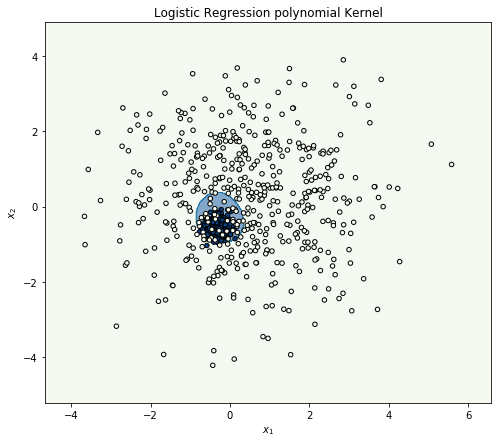

Test error: 4.80%


In [14]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler().fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

kernel = 'polynomial'
sigma = .1
lambd = .001
model = KernelLogisticRegression(lambd=lambd, kernel=kernel, sigma=sigma, degree=4)
y_pred = model.fit(X_train_scaled, y_train).predict(X_test_scaled)
plot_decision_function(model, X_test_scaled, y_test,
                       title='Logistic Regression {} Kernel'.format(kernel))
print('Test error: {:.2%}'.format(error(y_pred, y_test)))